### 1

#### Uploading the data on arangodb

In [1]:
from arango import ArangoClient
#This
client = ArangoClient(hosts=f"https://cf11b636595d.arangodb.cloud:8529/")
db = client.db('Fb', username='root', password='bYZR071o7NxwgNDLitbW')


In [2]:
def parse_txt_file(file_path):
    vertices = set()
    edges = []

    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()

            if not line or line.startswith("#"):
                continue

            from_node, to_node = line.split(' ')

            vertices.add(from_node)
            vertices.add(to_node)

            edges.append({"_from": "vertices/" + from_node, "_to": "vertices/" + to_node})

    return [{"_key": v} for v in vertices], edges

vertex_data, edge_data = parse_txt_file("facebook_combined.txt")

In [3]:
vertices = db.create_collection("vertices")
edges = db.create_collection("edges", edge=True)

In [15]:
db.delete_collection("vertices")
vertices = db.create_collection("vertices")

In [16]:
vertices.insert_many(vertex_data)

[{'_id': 'vertices/847', '_key': '847', '_rev': '_f7D_CA6---'},
 {'_id': 'vertices/2505', '_key': '2505', '_rev': '_f7D_CA6--_'},
 {'_id': 'vertices/1008', '_key': '1008', '_rev': '_f7D_CA6--A'},
 {'_id': 'vertices/2946', '_key': '2946', '_rev': '_f7D_CA6--B'},
 {'_id': 'vertices/2456', '_key': '2456', '_rev': '_f7D_CA6--C'},
 {'_id': 'vertices/666', '_key': '666', '_rev': '_f7D_CA6--D'},
 {'_id': 'vertices/2682', '_key': '2682', '_rev': '_f7D_CA6--E'},
 {'_id': 'vertices/43', '_key': '43', '_rev': '_f7D_CA6--F'},
 {'_id': 'vertices/1045', '_key': '1045', '_rev': '_f7D_CA6--G'},
 {'_id': 'vertices/713', '_key': '713', '_rev': '_f7D_CA6--H'},
 {'_id': 'vertices/1462', '_key': '1462', '_rev': '_f7D_CA6--I'},
 {'_id': 'vertices/941', '_key': '941', '_rev': '_f7D_CA6--J'},
 {'_id': 'vertices/3054', '_key': '3054', '_rev': '_f7D_CA6--K'},
 {'_id': 'vertices/2342', '_key': '2342', '_rev': '_f7D_CA6--L'},
 {'_id': 'vertices/373', '_key': '373', '_rev': '_f7D_CA6--M'},
 {'_id': 'vertices/1726'

In [59]:
db.delete_collection("edges")

True

In [60]:
edges = db.create_collection('edges', edge=True)

In [61]:
batch_size = 1000
for i in range(0, len(edge_data), batch_size):
    batch = edge_data[i:i + batch_size]
    edges.insert_many(batch)

In [62]:
print(db.collection('edges').count())

176468


In [21]:
collection_name = "edges"

# Define the AQL query to retrieve all documents from the collection
query = f"FOR doc IN {collection_name} LIMIT 1 RETURN doc"

# Execute the query and fetch the result
cursor = db.aql.execute(query)
first_document = cursor.next()

# Print the first document
print(first_document)

{'_key': '12520215', '_id': 'edges/12520215', '_from': 'vertices/0', '_to': 'vertices/1', '_rev': '_f6LFW1i---'}


In [27]:
query_vertices = '''
FOR v IN vertices
RETURN v
'''
cursor_vertices = db.aql.execute(query_vertices)
vertices = list(cursor_vertices)

print(vertices[0])

{'_key': '2179', '_id': 'vertices/2179', '_rev': '_f6LF_R2---'}


In [63]:
import json

# Define the AQL query to retrieve all edges from the collection
query = 'FOR edge IN edges RETURN edge'

# Execute the query and retrieve the edges
cursor = db.aql.execute(query)
edge_list = [json.dumps(edge) for edge in cursor]


In [50]:
import json


# Execute the query and retrieve the vertices
query = '''
    FOR v IN vertices
        RETURN v
'''
cursor = db.aql.execute(query)
vertices = [json.dumps(vertex) for vertex in cursor]
print(vertices[:10])

['{"_key": "2179", "_id": "vertices/2179", "_rev": "_f6LF_R2---"}', '{"_key": "2570", "_id": "vertices/2570", "_rev": "_f6LF_R2--_"}', '{"_key": "3976", "_id": "vertices/3976", "_rev": "_f6LF_R2--A"}', '{"_key": "3881", "_id": "vertices/3881", "_rev": "_f6LF_R2--B"}', '{"_key": "321", "_id": "vertices/321", "_rev": "_f6LF_R2--C"}', '{"_key": "3592", "_id": "vertices/3592", "_rev": "_f6LF_R2--D"}', '{"_key": "277", "_id": "vertices/277", "_rev": "_f6LF_R2--E"}', '{"_key": "2787", "_id": "vertices/2787", "_rev": "_f6LF_R2--F"}', '{"_key": "1327", "_id": "vertices/1327", "_rev": "_f6LF_R2--G"}', '{"_key": "654", "_id": "vertices/654", "_rev": "_f6LF_R2--H"}']


In [64]:
print(len(edge_list))

176468


In [75]:
print(len(vertices))

4039


In [77]:
if len(set(vertices)) != len(vertices):
    print("Duplicates found in the vertices list!")
else:
    print(False)

False


#### Plotting the graph

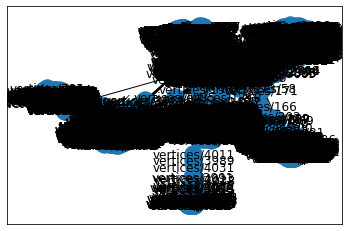

In [86]:
import networkx as nx
import arango
import matplotlib.pyplot as plt



# Create the NetworkX graph and add nodes and edges
nx_graph = nx.Graph()
for vertex in vertices:
    if isinstance(vertex, dict):  # Ensure that vertex is a dictionary
        nx_graph.add_node(vertex['_id'])
for edge in edges:
    if isinstance(edge, dict):  # Ensure that edge is a dictionary
        nx_graph.add_edge(edge['_from'], edge['_to'])

# Visualize the graph
pos = nx.spring_layout(nx_graph)
plt.figure(figsize=(10, 10))
nx.draw_networkx(nx_graph, pos=pos)
plt.show()



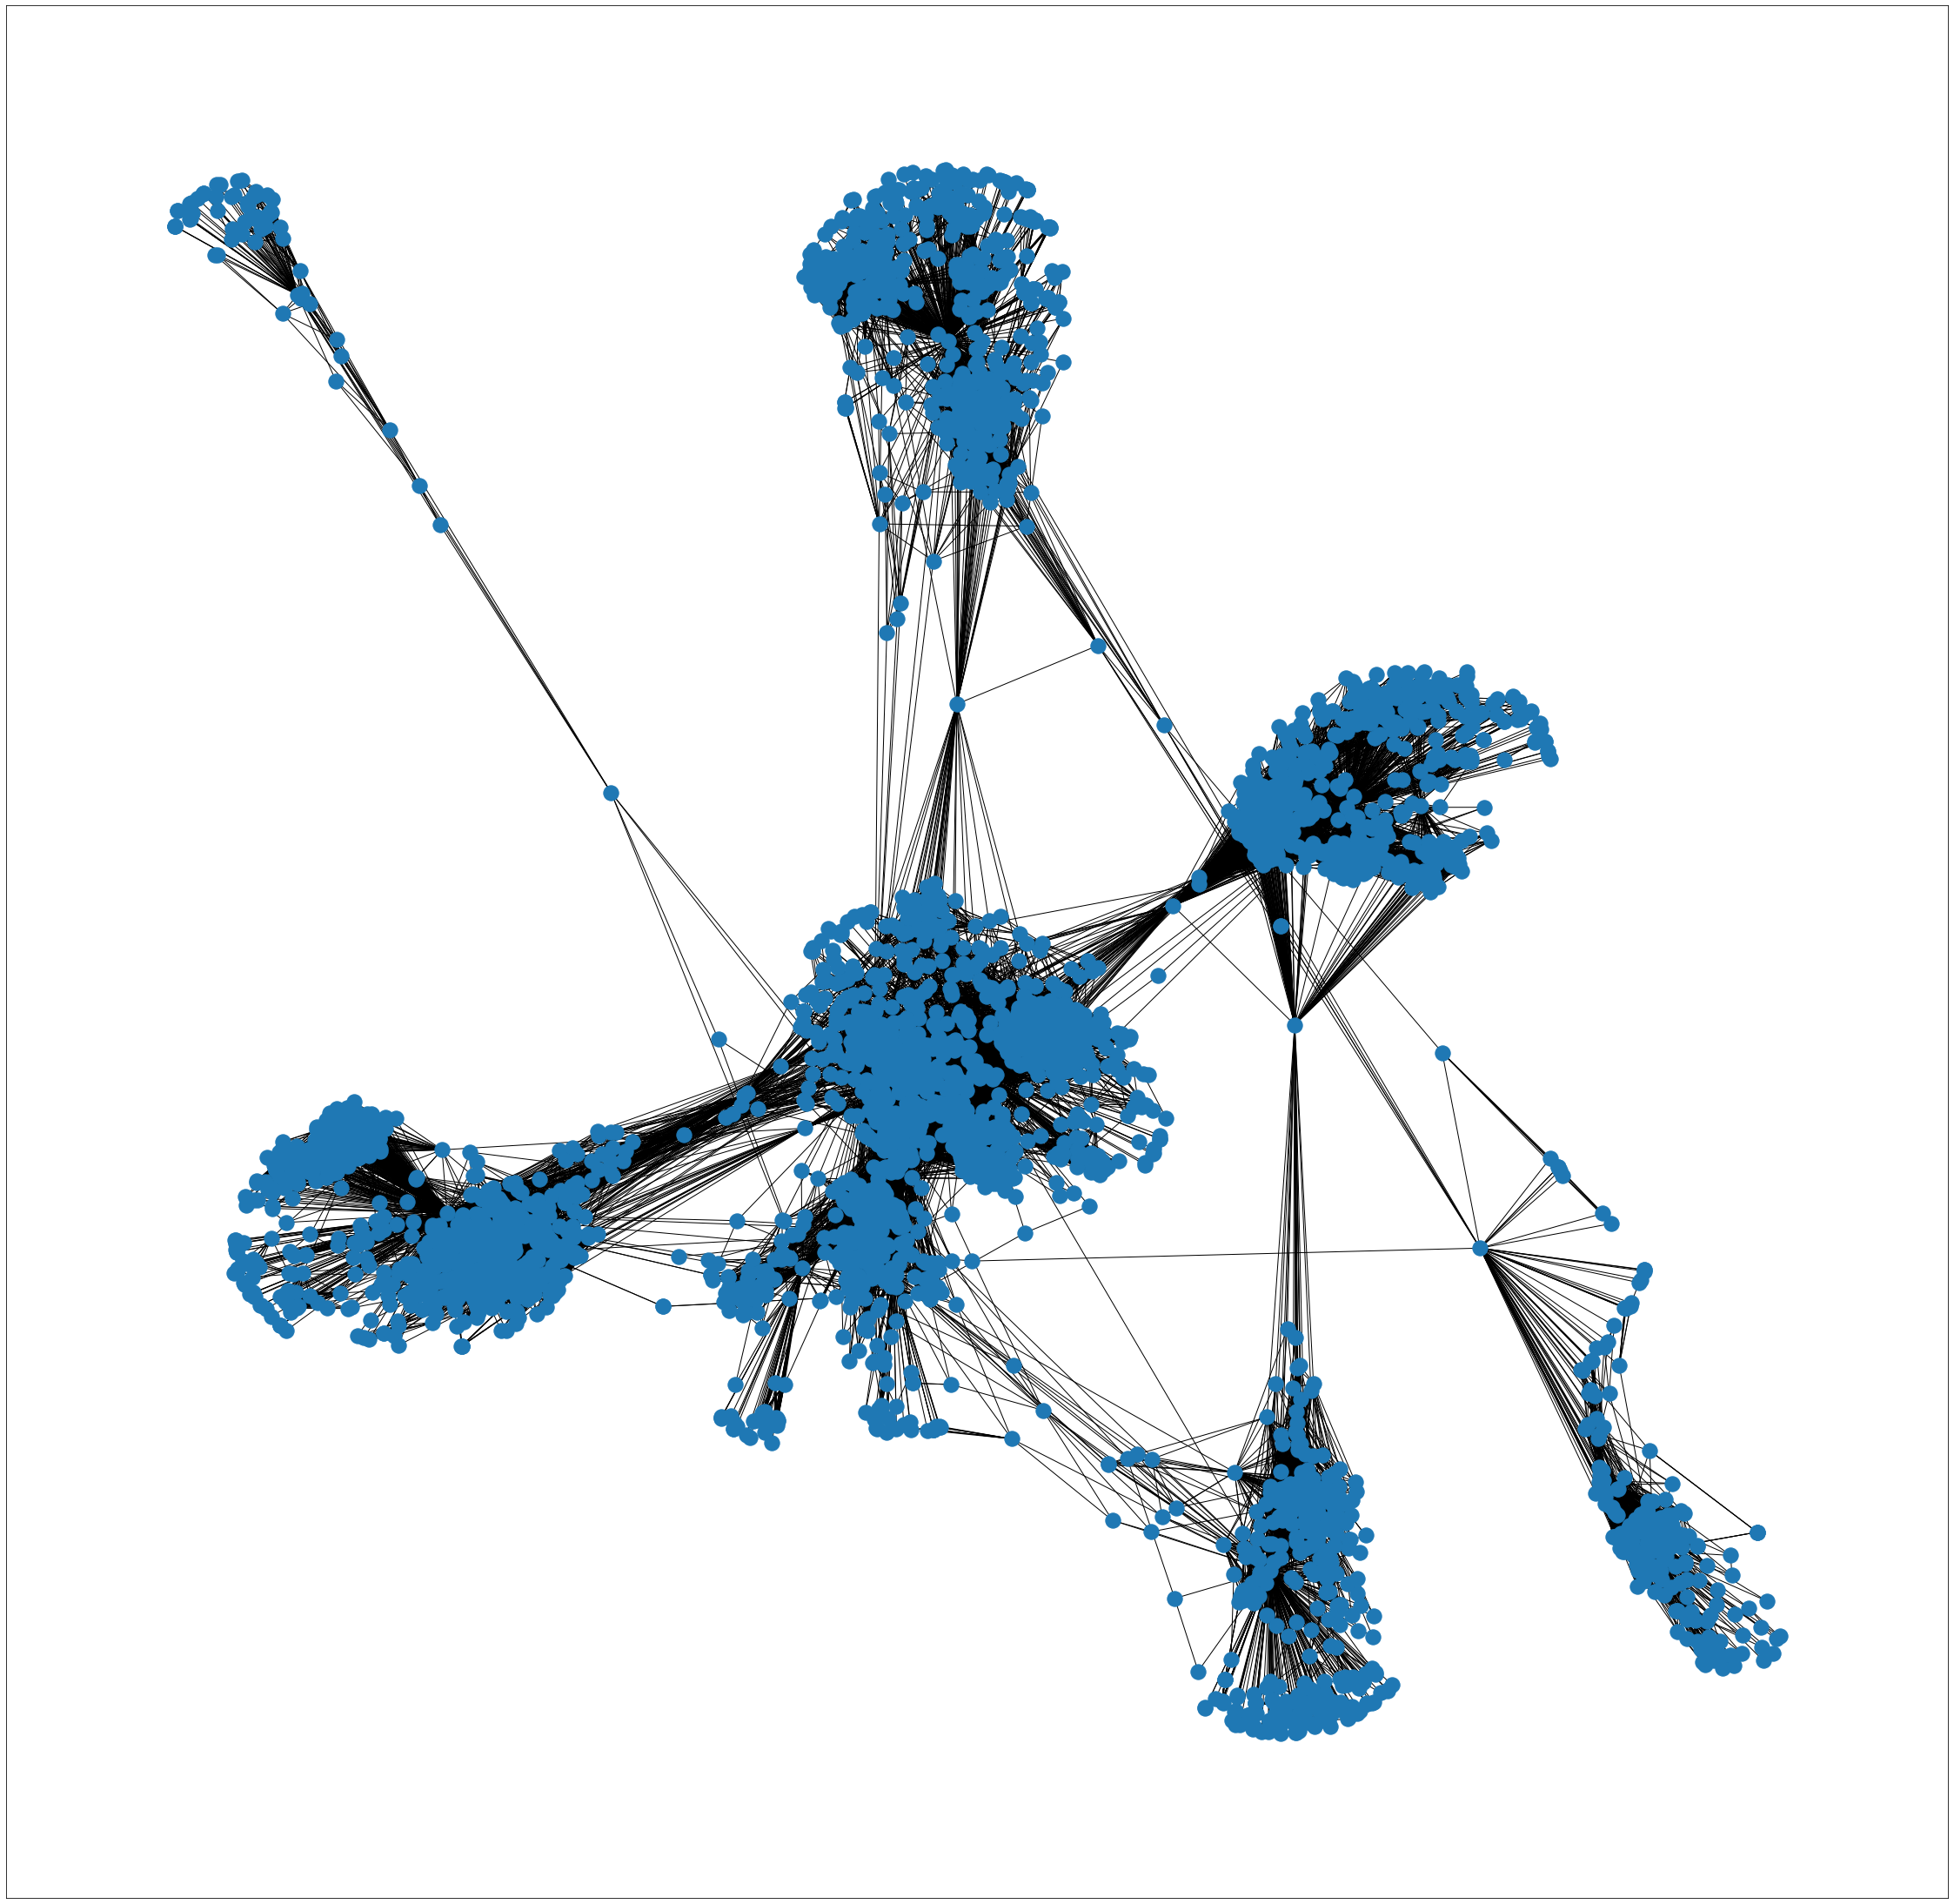

In [91]:
pos = nx.spring_layout(nx_graph)
plt.figure(figsize=(40, 40))
nx.draw_networkx(nx_graph, pos=pos, with_labels=False)
plt.show()

In [89]:
print(len(nx.nodes(nx_graph)), len(nx.edges(nx_graph)))

4039 88234


#### Finding the top 10 nodes

In [8]:
from arango.graph import Graph

graph = db.create_graph('fb_graph')

In [2]:
def execute_query(query):
    cursor = db.aql.execute(query)
    return list(cursor)
# this

query = '''
FOR v IN vertices
  COLLECT k = v._key WITH COUNT INTO degree
  SORT degree DESC
  LIMIT 10
  RETURN { "key": k, "degree": degree }
'''
top_10_nodes = execute_query(query)


In [3]:
print("Top 10 nodes are: ")
for i in top_10_nodes:
  print(i)

Top 10 nodes are: 
{'key': '2632', 'degree': 1}
{'key': '730', 'degree': 1}
{'key': '2344', 'degree': 1}
{'key': '3015', 'degree': 1}
{'key': '90', 'degree': 1}
{'key': '1347', 'degree': 1}
{'key': '3437', 'degree': 1}
{'key': '1226', 'degree': 1}
{'key': '1951', 'degree': 1}
{'key': '2268', 'degree': 1}


#### Extracting a subgraph of 1000 nodes

In [113]:
import random
# Define the node probability
p = 0.5

# Create subgraph of 1000 nodes
subgraph_nodes = random.sample(nx_graph.nodes(),  int(len(nx_graph.nodes())*p))
subgraph_nodes = [n for n in subgraph_nodes if random.random() <= p]
subgraph = nx_graph.subgraph(subgraph_nodes)

# Print subgraph
print(subgraph)

Graph with 1006 nodes and 6655 edges


C:\Users\DELL\AppData\Local\Temp/ipykernel_26600/3139796299.py:6: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  subgraph_nodes = random.sample(nx_graph.nodes(),  int(len(nx_graph.nodes())*p))


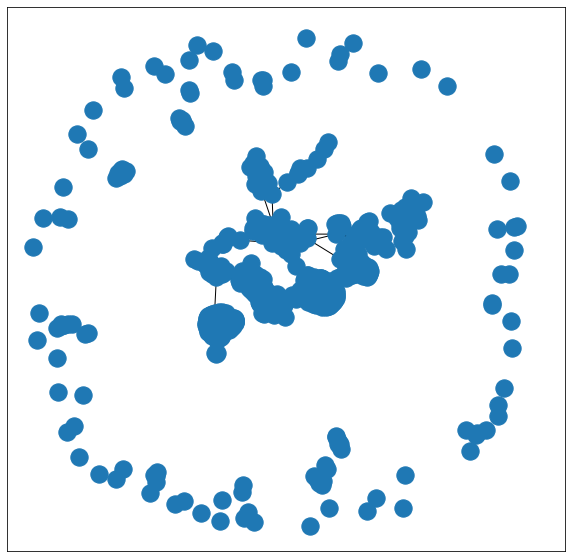

In [115]:
pos = nx.spring_layout(subgraph)
plt.figure(figsize=(10, 10))
nx.draw_networkx(subgraph, pos=pos, with_labels=False)
plt.show()

In [102]:
print(len(nx.nodes(nx_subgraph)), len(nx.edges(nx_subgraph)))

1000 4960


### 2

#### Finding communities using louvain algorithm

In [127]:
import igraph as ig

# Load vertices and edges from ArangoDB
vertex_data = execute_query("FOR v IN vertices RETURN v")
edge_data = execute_query("FOR e IN edges RETURN e")

# Create the igraph graph
g = ig.Graph.TupleList([(e["_from"], e["_to"]) for e in edge_data], directed=False)

# Perform community detection using the Louvain method
louvain_communities = g.community_multilevel()

In [149]:
print(f"Number of communities: {len(louvain_communities)}")

Number of communities: 16


In [128]:
# Get the membership list
membership = louvain_communities.membership

# Count the number of members in each community
from collections import Counter
community_counts = Counter(membership)

# Get the 4 largest communities based on member count
top_communities = community_counts.most_common(4)

# Print the top 4 communities
for i, (community_id, count) in enumerate(top_communities, start=1):
    print(f"Community {i}: ID: {community_id}, Size: {count}")

Community 1: ID: 7, Size: 548
Community 2: ID: 4, Size: 537
Community 3: ID: 2, Size: 435
Community 4: ID: 1, Size: 432


#### Plotting a graph with each community represented by different colour

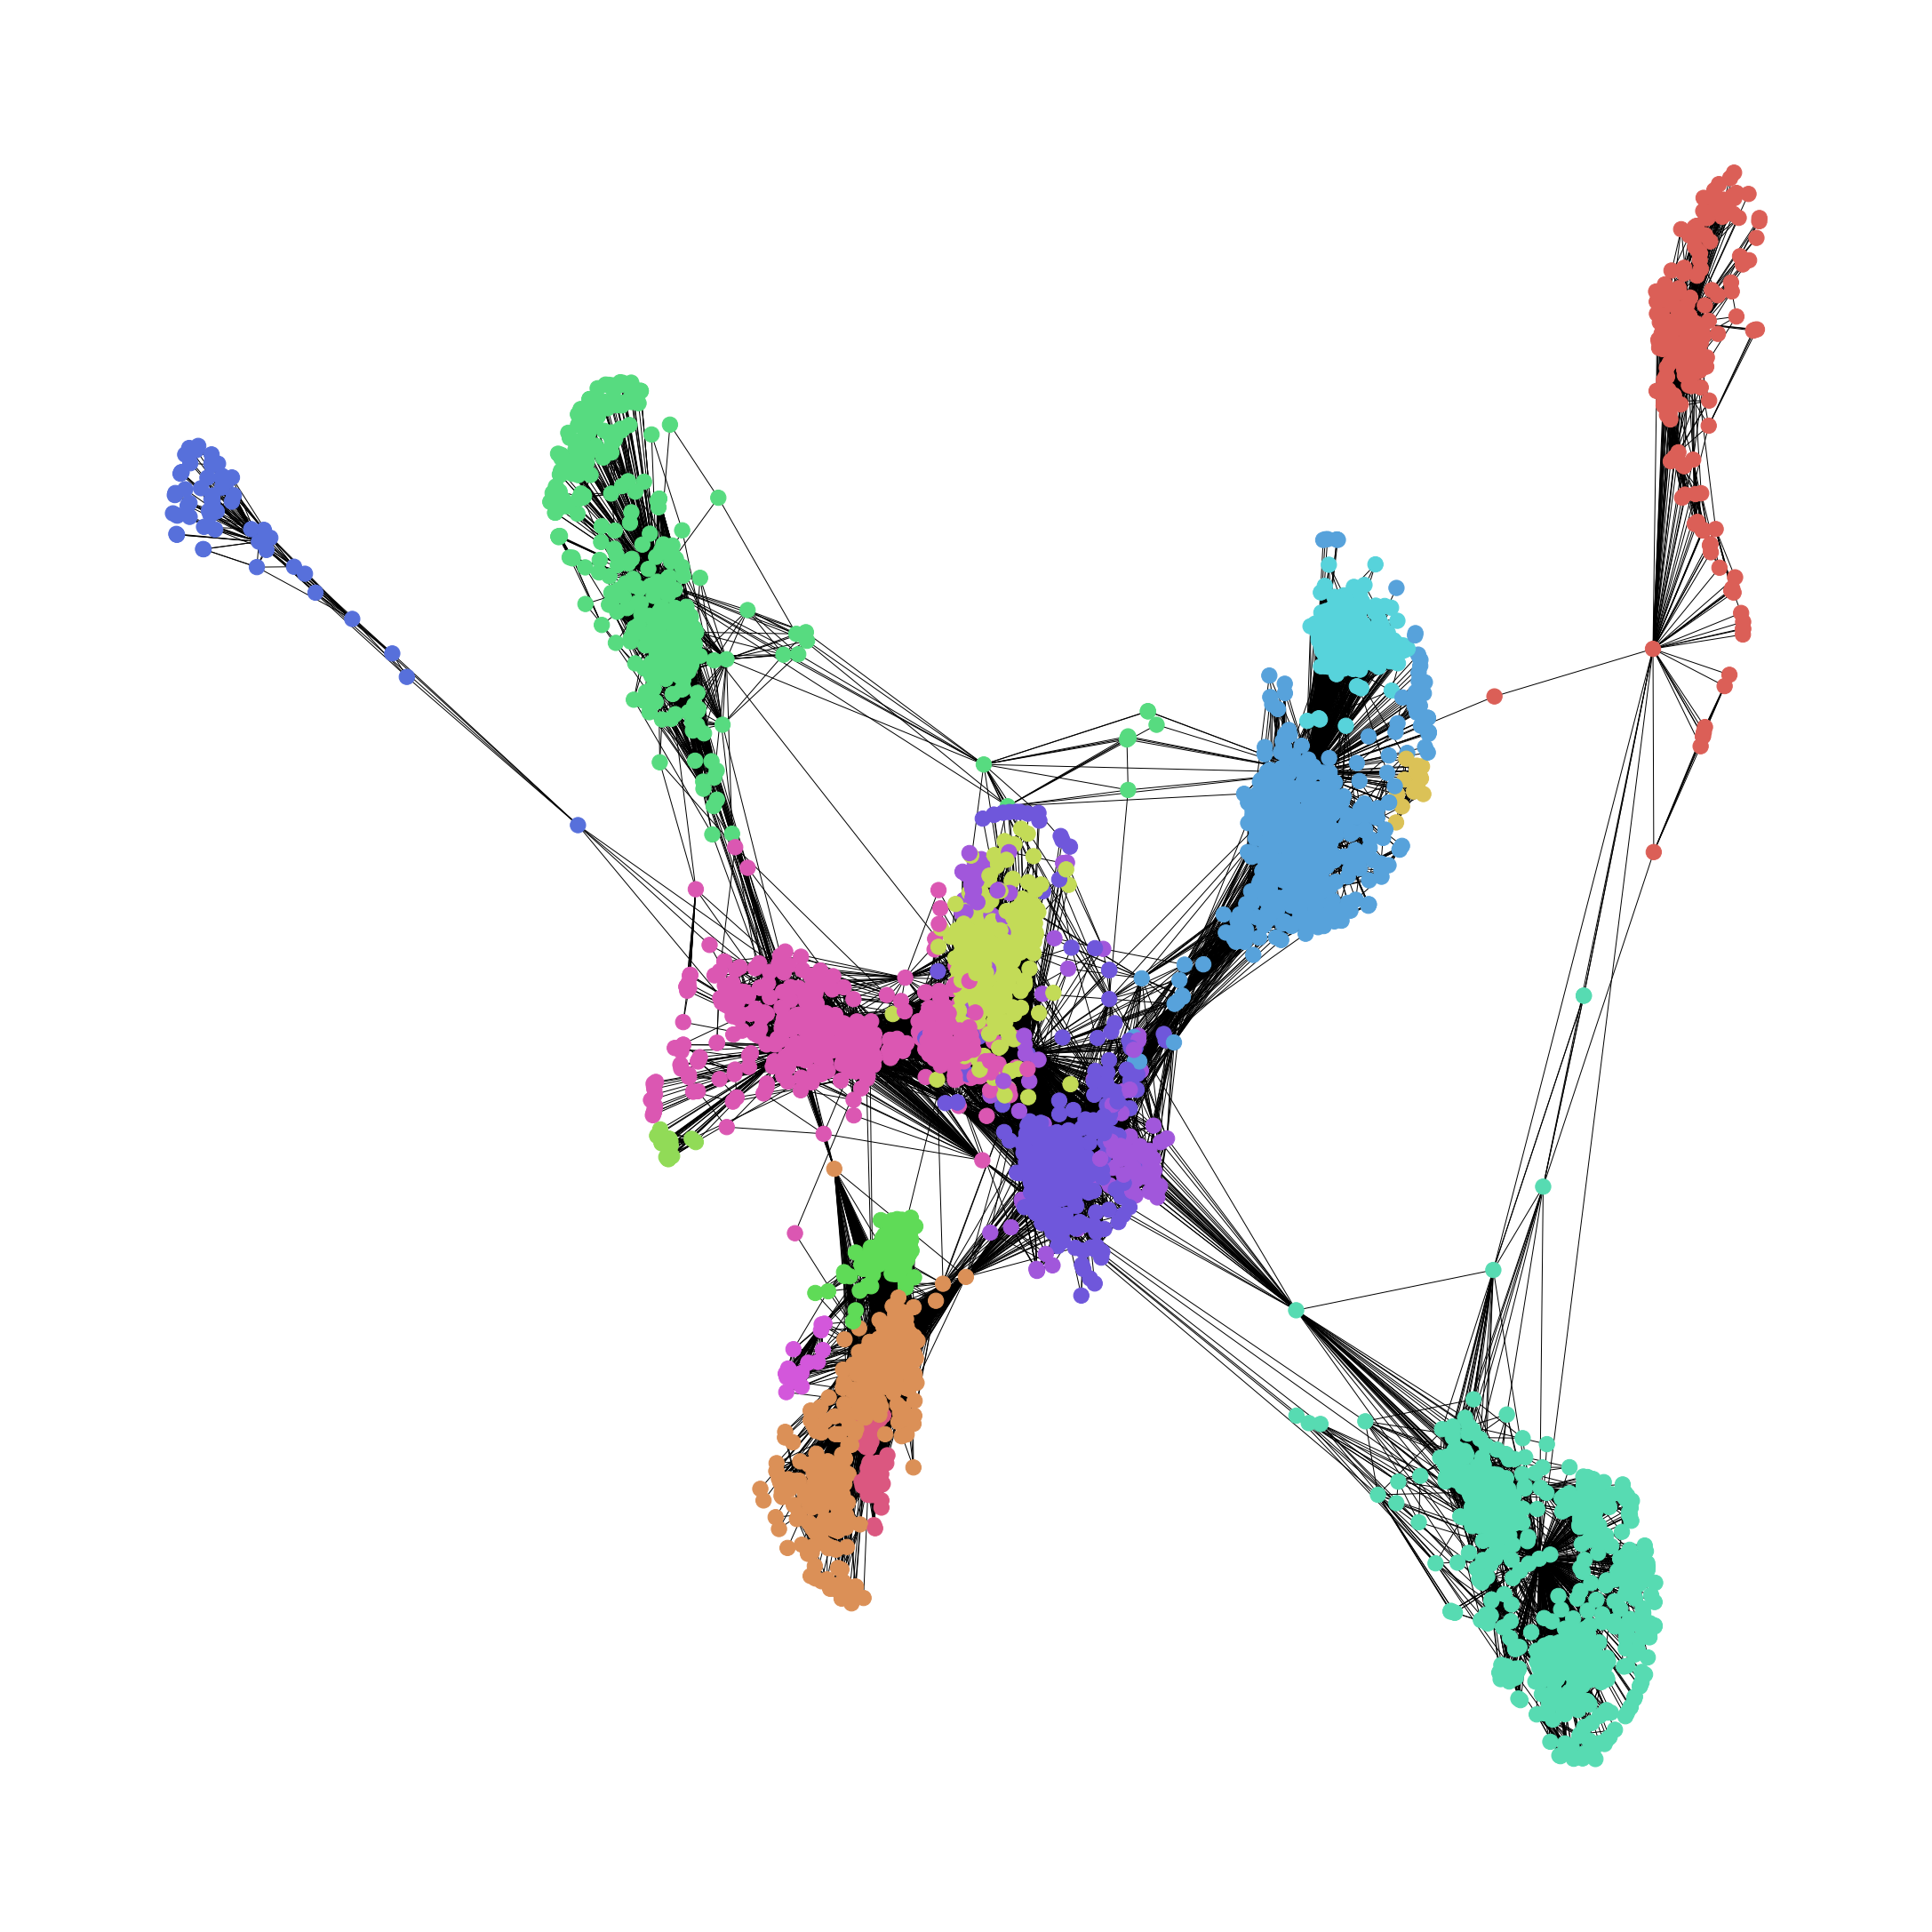

In [148]:
import networkx as nx
import seaborn as sns

# Assuming you already have a networkx graph called nx_graph with communities assigned as node attributes

communities = set()
for node in nx_graph.nodes:
    node_attr = nx_graph.nodes[node]
    if 'community' in node_attr and isinstance(node_attr['community'], dict):
        communities.add(tuple(node_attr['community'].items()))

# Generate a list of colors equal to the number of communities
colors = sns.color_palette("hls", len(communities))

# Plot the graph with each node colored by its community
# Generate node colors
node_colors = [colors[list(communities).index(tuple(nx_graph.nodes[node]['community'].items()))] if 'community' in nx_graph.nodes[node] and isinstance(nx_graph.nodes[node]['community'], dict) else 'black' for node in nx_graph.nodes]
pos = nx.spring_layout(nx_graph)
plt.figure(figsize=(30,30))
# You can change the layout algorithm here
nx.draw(nx_graph, pos, node_color=node_colors)
plt.show()

In [140]:
for node in nx_graph.nodes:
    print(node, nx_graph.nodes[node])


0 {'_nx_name': 'vertices/0', 'community': {'id': 0}}
1 {'_nx_name': 'vertices/1', 'community': {'id': 0}}
2 {'_nx_name': 'vertices/2', 'community': {'id': 0}}
3 {'_nx_name': 'vertices/3', 'community': {'id': 0}}
4 {'_nx_name': 'vertices/4', 'community': {'id': 0}}
5 {'_nx_name': 'vertices/5', 'community': {'id': 0}}
6 {'_nx_name': 'vertices/6', 'community': {'id': 0}}
7 {'_nx_name': 'vertices/7', 'community': {'id': 0}}
8 {'_nx_name': 'vertices/8', 'community': {'id': 0}}
9 {'_nx_name': 'vertices/9', 'community': {'id': 0}}
10 {'_nx_name': 'vertices/10', 'community': {'id': 0}}
11 {'_nx_name': 'vertices/11', 'community': {'id': 0}}
12 {'_nx_name': 'vertices/12', 'community': {'id': 0}}
13 {'_nx_name': 'vertices/13', 'community': {'id': 0}}
14 {'_nx_name': 'vertices/14', 'community': {'id': 0}}
15 {'_nx_name': 'vertices/15', 'community': {'id': 0}}
16 {'_nx_name': 'vertices/16', 'community': {'id': 0}}
17 {'_nx_name': 'vertices/17', 'community': {'id': 0}}
18 {'_nx_name': 'vertices/18',

### 3

In [17]:
db.delete_collection("edge2")

True

In [18]:
db.delete_graph('FB2')

True

In [19]:
edge2 = db.create_collection('edge2' , edge=True , shard_fields=['vertex'] , shard_like='vertices')

In [20]:
batch_size = 1000
for i in range(0, len(edge_data), batch_size):
    batch = edge_data[i:i + batch_size]
    edge2.insert_many(batch)

In [21]:

# Create a graph called "my_graph" with edge definitions
graph = db.create_graph('FB2')

# Use existing vertex collection 'vertices'
vertices = graph.vertex_collection('vertices')

# Create the edge definition using the existing 'edges' collection
edges = graph.create_edge_definition(
    edge_collection='edge2',
    from_vertex_collections=['vertices'],
    to_vertex_collections=['vertices']
)

In [22]:
db.graphs()

[{'id': '_graphs/fb_graph',
  'name': 'fb_graph',
  'revision': '_f6LGeKy---',
  'orphan_collections': [],
  'edge_definitions': [],
  'shard_count': 1,
  'replication_factor': 3},
 {'id': '_graphs/mygraph',
  'name': 'mygraph',
  'revision': '_f6mEywW--A',
  'orphan_collections': [],
  'edge_definitions': [{'edge_collection': 'edges',
    'from_vertex_collections': ['vertices'],
    'to_vertex_collections': ['vertices']}],
  'shard_count': 1,
  'replication_factor': 3},
 {'id': '_graphs/fb',
  'name': 'fb',
  'revision': '_f6mGOz2--A',
  'orphan_collections': [],
  'edge_definitions': [{'edge_collection': 'edges',
    'from_vertex_collections': ['vertices'],
    'to_vertex_collections': ['vertices']}],
  'shard_count': 1,
  'replication_factor': 3},
 {'id': '_graphs/FB',
  'name': 'FB',
  'revision': '_f6vXNlG--_',
  'orphan_collections': [],
  'edge_definitions': [{'edge_collection': 'edges',
    'from_vertex_collections': ['vertices'],
    'to_vertex_collections': ['vertices']}],
  

#### Page Rank

In [26]:
# Get the Pregel API wrapper.
pregel = db.pregel

# Start a new Pregel job in "FB2" graph.
job_id = pregel.create_job(
    graph = 'FB2',
    algorithm='pagerank',
    store= True,
    max_gss=100,
    thread_count=1,
    async_mode=False,
    result_field='result_pagerank',
    algorithm_params={'threshold': 0.001},
)

# Retrieve details of a Pregel job by ID.
job = pregel.job(job_id)

In [27]:
print(job)

{'id': '1099522491884', 'algorithm': 'PageRank', 'created': '2023-04-30T08:25:22Z', 'ttl': 600, 'state': 'running', 'gss': 1, 'total_runtime': 0.141465668, 'startup_time': 0.113112197, 'computation_time': 0.028354126, 'gssTimes': [0.009321036, 0.018483059], 'reports': [], 'vertex_count': 4039, 'edge_count': 88234, 'aggregators': {'convergence': 1.000247597694397}, 'received_count': 0, 'send_count': 88234, 'detail': {'aggregatedStatus': {'timeStamp': '2023-04-30T08:25:23Z', 'graphStoreStatus': {'verticesLoaded': 4039, 'edgesLoaded': 88234, 'memoryBytesUsed': 1898799}, 'allGssStatus': {'items': [{'verticesProcessed': 4039, 'messagesSent': 88234, 'messagesReceived': 0, 'memoryBytesUsedForMessages': 352936}]}}, 'workerStatus': {'PRMR-tl4nozkl': {'timeStamp': '2023-04-30T08:25:23Z', 'graphStoreStatus': {'verticesLoaded': 4039, 'edgesLoaded': 88234, 'memoryBytesUsed': 1898799}, 'allGssStatus': {'items': [{'verticesProcessed': 4039, 'messagesSent': 88234, 'messagesReceived': 0, 'memoryBytesUs

In [28]:
result = db.aql.execute("FOR v IN vertices RETURN {id: v._key,  pagerank: v.result_pagerank}")
print(list(result))

[{'id': '847', 'pagerank': 0.0003535781579557806}, {'id': '2505', 'pagerank': 9.199889609590173e-05}, {'id': '1008', 'pagerank': 3.7170590076129884e-05}, {'id': '2946', 'pagerank': 7.137353532016277e-05}, {'id': '2456', 'pagerank': 0.00011449734302004799}, {'id': '666', 'pagerank': 0.0002652688417583704}, {'id': '2682', 'pagerank': 3.726117211044766e-05}, {'id': '43', 'pagerank': 3.722887777257711e-05}, {'id': '1045', 'pagerank': 4.950415313942358e-05}, {'id': '713', 'pagerank': 5.49412943655625e-05}, {'id': '1462', 'pagerank': 0.00010598944209050387}, {'id': '941', 'pagerank': 3.863833626382984e-05}, {'id': '3054', 'pagerank': 0.00011285216896794736}, {'id': '2342', 'pagerank': 7.56669178372249e-05}, {'id': '373', 'pagerank': 4.363401239970699e-05}, {'id': '1726', 'pagerank': 9.457005944568664e-05}, {'id': '1847', 'pagerank': 0.0004357027355581522}, {'id': '3700', 'pagerank': 4.8886715376283973e-05}, {'id': '2555', 'pagerank': 0.0003720780950970948}, {'id': '3234', 'pagerank': 0.00014

In [33]:
max_result = db.aql.execute("FOR v IN vertices FILTER v.result_pagerank == MAX(FOR u IN vertices RETURN u.result_pagerank)RETURN {id: v._key, pagerank: v.result_pagerank}")
print(list(max_result)) #Node with highest importance

[{'id': '3434', 'pagerank': 0.00779984425753355}]


In [34]:
pregel.delete_job(job_id)

True

#### Hits

In [90]:
# Start a new Pregel job in the "FB2" graph.
job_id = pregel.create_job(
    graph='FB2',
    algorithm='hits',
    store=True,
    max_gss=100,
    thread_count=1,
    async_mode=False,
    result_field='result_hits',
    algorithm_params={'threshold':0.001}
)

# Retrieve details of the Pregel job by ID.
job = pregel.job(job_id)

In [91]:
# Get the result of the job.
result = db.aql.execute('FOR v IN vertices RETURN {id: v._key, hits: v.result_hits_hub}')
print(list(result))

[{'id': '847', 'hits': 1.2923305268639614e-14}, {'id': '2505', 'hits': 0.001388861118991718}, {'id': '1008', 'hits': 6.6307204886328e-05}, {'id': '2946', 'hits': 1.6438275203784734e-07}, {'id': '2456', 'hits': 0.0013478110286373537}, {'id': '666', 'hits': 2.4277870126487982e-09}, {'id': '2682', 'hits': 3.0770451273476544e-07}, {'id': '43', 'hits': 0}, {'id': '1045', 'hits': 3.580178282327478e-06}, {'id': '713', 'hits': 5.305812007084651e-12}, {'id': '1462', 'hits': 1.5719798730215916e-05}, {'id': '941', 'hits': 2.4413537092472264e-05}, {'id': '3054', 'hits': 1.594557475252035e-08}, {'id': '2342', 'hits': 0.020442678020011193}, {'id': '373', 'hits': 8.979429512304175e-06}, {'id': '1726', 'hits': 2.2473927360165716e-07}, {'id': '1847', 'hits': 4.3861184511311935e-07}, {'id': '3700', 'hits': 2.8014380767948467e-09}, {'id': '2555', 'hits': 0.12086769023835756}, {'id': '3234', 'hits': 3.7578623967611185e-09}, {'id': '3658', 'hits': 3.066644872526208e-09}, {'id': '1386', 'hits': 0}, {'id': '

In [92]:
max_result = db.aql.execute("FOR v IN vertices FILTER v.result_hits_auth == MAX(FOR u IN vertices RETURN u.result_hits_auth)RETURN {id: v._key, hits: v.result_hits_auth}")
print(list(max_result)) #identifying the most authoritative pages in a network 

[{'id': '2604', 'hits': 11.968819090566576}]


In [93]:
min_result = db.aql.execute("FOR v IN vertices FILTER v.result_hits_auth == MIN(FOR u IN vertices RETURN u.result_hits_auth)RETURN {id: v._key, hits: v.result_hits_auth}")
print(list(min_result)) #identifying the least authoritative pages in a network 

[{'id': '0', 'hits': 0}, {'id': '686', 'hits': 0}]


In [94]:
pregel.delete_job(job_id)

True

#### Label Propagation

In [75]:


# Create a new Pregel job in the "mygraph" graph
pregel = db.pregel
job_id = pregel.create_job(graph = "FB2", algorithm = "labelpropagation" , store = True , max_gss=100,result_field='result_lp')

# Get the Pregel job details
job = pregel.job(job_id)

# Retrieve the result
result = db.aql.execute("""
    FOR v IN vertices
        RETURN {id: v._key, connected: v.result_lp}
""")

In [76]:
print(list(result))

[{'id': '847', 'connected': 12248387}, {'id': '2505', 'connected': 12248392}, {'id': '1008', 'connected': 12248380}, {'id': '2946', 'connected': 12248392}, {'id': '2456', 'connected': 12248392}, {'id': '666', 'connected': 12248703}, {'id': '2682', 'connected': 12248384}, {'id': '43', 'connected': 12248385}, {'id': '1045', 'connected': 12249651}, {'id': '713', 'connected': 12248873}, {'id': '1462', 'connected': 12248389}, {'id': '941', 'connected': 12248389}, {'id': '3054', 'connected': 12248392}, {'id': '2342', 'connected': 12248392}, {'id': '373', 'connected': 12248703}, {'id': '1726', 'connected': 12248392}, {'id': '1847', 'connected': 12248392}, {'id': '3700', 'connected': 12248703}, {'id': '2555', 'connected': 12248392}, {'id': '3234', 'connected': 12248392}, {'id': '3658', 'connected': 12248703}, {'id': '1386', 'connected': 12248399}, {'id': '3703', 'connected': 12248703}, {'id': '1665', 'connected': 12248392}, {'id': '60', 'connected': 12248402}, {'id': '1789', 'connected': 12248

In [77]:
pregel.delete_job(job_id)

True

#### ECC

In [83]:
# Define the Pregel algorithm parameters
params = {
    'result_field': 'result_ecc',
    'max_gss': 100,
    'algorithm_params': {
        'threshold': 0.001
    }
}

# Start the Pregel algorithm
pregel = db.pregel
job_id = pregel.create_job(
    graph='FB2',
    algorithm='effectivecloseness',
    store=True,
    thread_count=1,
    async_mode=False,
    **params
)

# Retrieve the result
job = pregel.job(job_id)
result = db.aql.execute('FOR v IN vertices RETURN {id: v._key, ecc: v.result_ecc}')
print(list(result))

[{'id': '1493', 'ecc': 5.824937027707809}, {'id': '2557', 'ecc': 4.131306381556966}, {'id': '2669', 'ecc': 5.986477349560514}, {'id': '1529', 'ecc': 3.5365638766519822}, {'id': '54', 'ecc': 1.7777777777777777}, {'id': '1153', 'ecc': 4.420588235294118}, {'id': '3040', 'ecc': 6.569420783645656}, {'id': '3246', 'ecc': 5.892549718017216}, {'id': '3106', 'ecc': 5.493348536678069}, {'id': '407', 'ecc': 4.551020408163265}, {'id': '1296', 'ecc': 3.776796973518285}, {'id': '2156', 'ecc': 4.872701555869873}, {'id': '3224', 'ecc': 5.4848896434634975}, {'id': '225', 'ecc': 1.2222222222222223}, {'id': '3340', 'ecc': 5.0504301394245035}, {'id': '929', 'ecc': 1.6666666666666667}, {'id': '900', 'ecc': 2}, {'id': '1880', 'ecc': 4.478784040531982}, {'id': '1611', 'ecc': 3.7978363759296823}, {'id': '3237', 'ecc': 5.572884811416921}, {'id': '3805', 'ecc': 4.791237113402062}, {'id': '2300', 'ecc': 4.570882557331481}, {'id': '272', 'ecc': 1.7735849056603774}, {'id': '584', 'ecc': 3.471264367816092}, {'id': 

In [87]:
min_result = db.aql.execute("FOR v IN vertices FILTER v.result_ecc == MIN(FOR u IN vertices RETURN u.result_ecc)RETURN {id: v._key, ecc: v.result_ecc}")
print(list(min_result)) #indiaces these nodes are unreachable

[{'id': '49', 'hits': 0}, {'id': '0', 'hits': 0}, {'id': '686', 'hits': 0}, {'id': '46', 'hits': 0}, {'id': '32', 'hits': 0}]


In [88]:
max_result = db.aql.execute("FOR v IN vertices FILTER v.result_ecc == MAX(FOR u IN vertices RETURN u.result_ecc)RETURN {id: v._key, ecc: v.result_ecc}")
print(list(max_result)) # It represents the node that is most efficiently connected to all other nodes in the network

[{'id': '972', 'ecc': 7.993243243243243}]


In [89]:
pregel.delete_job(job_id)

True

### 4

In [104]:
import numpy as np
from sklearn import svm

In [144]:
clf = svm.SVC()

In [132]:
query = """
FOR v IN vertices
RETURN {id: v._key, score: v.result_hits_auth}
"""
result = db.aql.execute(query)

In [134]:
result_dict = {}
for doc in result:
    result_dict[doc['id']] = doc['score']

In [135]:
print(result_dict)

{'2505': 0.14264141947173953, '1008': 3.375528017193148e-05, '2946': 4.963189734569567e-08, '2456': 0.14282467645317834, '666': 1.922049125793169e-07, '2682': 3.697925250591814e-08, '43': 6.832942849931534e-06, '1045': 3.387110792658474e-05, '713': 3.343524792461684e-11, '1462': 4.538941654051378e-05, '941': 3.3861512831704585e-05, '3054': 5.851481364941658e-08, '2342': 0.15490656199091157, '373': 1.1645306539060815e-06, '1726': 5.754705549516893e-05, '1847': 3.688419906156252e-05, '3700': 1.1261913104892536e-09, '2555': 1.0011636402472097, '3234': 4.287491534075777e-08, '3658': 2.1770646434966078e-09, '1386': 3.375528017193148e-05, '3703': 2.361454119928439e-09, '1665': 0.0006941288260582949, '60': 1.0246637093860074e-05, '1789': 0.0006329606403785099, '2626': 0.15137907051197888, '3820': 1.0624013720294592e-09, '670': 9.721424840338865e-08, '3965': 1.0667954519243566e-09, '3426': 6.669407552671257e-08, '3233': 3.135825570165119e-06, '1707': 0.00106585773713197, '611': 1.0362585458462

In [149]:
X = []
y = []

In [150]:
edges_collection = db.collection("edge2")
for e in edges_collection.all():
    source_hits = e["_from"]
    source_vertex = source_hits.split('/')[1]
    target_hits = e['_to']
    target_vertex = target_hits.split('/')[1]
    if target_vertex in result_dict and source_vertex in result_dict:
        target_hits_without_prefix = result_dict[target_vertex]
        source_hits_without_prefix = result_dict[source_vertex]
        X.append([source_hits_without_prefix,target_hits_without_prefix])
        if 'label' in e:
            y.append(e['label'] == 'connected')
        else:
            # assign a default label
            y.append(True)

In [5]:


# Define the collections
nodes_collection = 'vertices'
edges_collection = 'edges'
nodes_without_edges_collection = 'nodes_without_edges'

# Create the new collection for storing nodes without edges
if not db.has_collection(nodes_without_edges_collection):
    db.create_collection(nodes_without_edges_collection)

nodes_cursor = db.collection(nodes_collection).all()
nodes = [node for node in nodes_cursor]
node_pairs = [(node1, node2) for idx1, node1 in enumerate(nodes) for node2 in nodes[idx1 + 1:]]

# Check if the nodes have an edge together and insert nodes without edges into the new collection
for node1, node2 in node_pairs:
    query = f"""
    FOR edge IN {edges_collection}
        FILTER (edge._from == '{node1['_id']}' AND edge._to == '{node2['_id']}') OR (edge._from == '{node2['_id']}' AND edge._to == '{node1['_id']}')
        RETURN edge
    """

    cursor = db.aql.execute(query)
    if cursor.count() == 0:
        nodes_without_edges_doc = {
            'node1_id': node1['_id'],
            'node2_id': node2['_id']
        }
        db.collection(nodes_without_edges_collection).insert(nodes_without_edges_doc)

print("Nodes without edges have been inserted into the 'nodes_without_edges' collection.")


KeyboardInterrupt: 

In [3]:
graph_name = 'FB2'
graph = db.graph(graph_name)

# Count the number of nodes in the graph
vertex_collections = graph.vertex_collections()
total_nodes = 0

for vertex_collection in vertex_collections:
    total_nodes += db.collection(vertex_collection).count()
print(f"The total number of nodes in the graph '{graph_name}' is: {total_nodes}")

The total number of nodes in the graph 'FB2' is: 4039
